## Coursera Capstone Project: Opening a Chinese Restaurant in Brooklyn, New York 

### 1 Introduction

New York is the largest city in the United States with a long history of international immigration. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States. The New York City Metropolitan Area contains the largest ethnic Chinese population outside Asia.   
In the recent decades, American people especially show more and more interests in Chinese Food. However, when it comes to Chinese food, Americans have a stereotype of cheap, dirty, unhealthy, etc. It’s hard to people to associate Chinese restaurants with high-end restaurants.  

#### 1.1	Business Problem  
Our stakeholder is willing to open a high-end Chinese restaurant in New York City with middle-high level prices. Of course, choosing a location for business is one of the stressful and controversial tasks, since there are a lot of criteria that have to be satisfied in order to achieve the highest revenue. Here are some of them:
- the density of other restaurants
- the density of specifically Chinese restaurants
- population density around the location
- solvency of the population around the location
- Neighborhood HH Income, etc.

In this project, we will implement the basic analysis and try to find the most optimal Borough to open the high-end Chinese restaurant according to those criteria. It's obvious, that there are many additional factors, such as distance from parking places or distance from the main streets, but this analysis can be done after choosing the Borough, and thus will not be done within the scope of this project.


### 2 Data
#### 2.1 Data Description
Based on criteria listed above the following data will be utilized in our analysis:
- the number of restaurants within the certain radius of each borough (Foresquare API)
- the net income per person in each borough. Since the restaurant will have middle-high prices, it is important to consider the solvency of population. Source: Kaggle (https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations/version/8#)
- the population and the population density of the borough. Source: NYC Open Data (https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp)
- the coordinates of the borough. Source: NYU (https://geo.nyu.edu/catalog/nyu-2451-34572)


#### 2.2 Data Preparation
First we need to import all the libraries that necessary

In [36]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import os
import re
import pickle
print('Libraries imported.')

Libraries imported.


#### Get New York Borough Latitude and Longitude data

In [9]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] # define the dataframe columns
neighborhoods = pd.DataFrame(columns=column_names)# create the dataframe
for i in range(len(neighborhoods_data)): #Iterate through each entry in the JSON file
    borough = neighborhoods_data[i]['properties']['borough'] #Boroughs first
    neighborhood_name = neighborhoods_data[i]['properties']['name'] #Followed by Neighborhood name
    neighborhood_lat = neighborhoods_data[i]['properties']['bbox'][1] #Now latitude
    neighborhood_lon = neighborhoods_data[i]['properties']['bbox'][2] #And longitude
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [23]:
mask = neighborhoods['Borough'] == 'Brooklyn' #Make a boolean mask for Brooklyn Borough
df = neighborhoods.copy() #Make a copy to leave our original DF intact
df = df[mask] #Now use the mask to eliminate entries not in Manhattan
df.reset_index(inplace = True) #Now reset the index so we can use it
df.drop('index', axis = 1, inplace = True)
df.head() #And take a look at our work so far

Borough Neighborhood   Latitude  Longitude
0  Brooklyn    Bay Ridge  40.625801 -74.030621
1  Brooklyn  Bensonhurst  40.611009 -73.995180
2  Brooklyn  Sunset Park  40.645103 -74.010316
3  Brooklyn   Greenpoint  40.730201 -73.954241
4  Brooklyn    Gravesend  40.595260 -73.973471

#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>bk_explorer</em>, as shown below.

In [14]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="bk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


Set up Foursquare account and get the data

In [103]:
CLIENT_ID = '2RRWOHHNVVISQBJIYJYFVTTV5JNGJFPEW2FX55EAKRZKXO3D' # your Foursquare ID
CLIENT_SECRET = 'N4ZPV3P0VQE3JNOZOBFDWS0FVZF43R0XYMESLKSFBXLLFEIY' # No peeking at my secret key
VERSION = '20180605' # Foursquare API version

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID'          
                            ]
    
    return(nearby_venues)

In [87]:
#Use the function to pull venues near each neighborhood
LIMIT = 20
brooklyn_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [104]:
brooklyn_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Bay Ridge              40.625801              -74.030621   
1    Bay Ridge              40.625801              -74.030621   
2    Bay Ridge              40.625801              -74.030621   
3    Bay Ridge              40.625801              -74.030621   
4    Bay Ridge              40.625801              -74.030621   

                         Venue  Venue Latitude  Venue Longitude  \
0  Pilo Arts Day Spa and Salon       40.624748       -74.030591   
1                    Bagel Boy       40.627896       -74.029335   
2                 Pegasus Cafe       40.623168       -74.031186   
3                Cocoa Grinder       40.623967       -74.030863   
4          Ho' Brah Taco Joint       40.622960       -74.031371   

   Venue Category                  Venue ID  
0             Spa  4b895827f964a5206c2d32e3  
1      Bagel Shop  4ad09cf7f964a520bed820e3  
2  Breakfast Spot  4abe4e84f964a520958c20e3  
3       Juice Bar  538ca7d5498ec684c6387a46  
4      Taco Place  4ea17d24e5facb29c6d81d6f

In [105]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 223 uniques categories.


In [106]:
list = brooklyn_venues['Venue Category'].unique().tolist()
len(list)

223

Since we are opening a restaurant business, we want to filter data to only contains related categories 

In [91]:
matching = [s for s in list if "Restaurant" in s] + [s for s in list if "Bar" in s] + [s for s in list if "Food" in s] + [s for s in list if "Dessert" in s]
matching

['Middle Eastern Restaurant',
 'Caucasian Restaurant',
 'Greek Restaurant',
 'Italian Restaurant',
 'Sushi Restaurant',
 'Shabu-Shabu Restaurant',
 'Hotpot Restaurant',
 'Russian Restaurant',
 'Chinese Restaurant',
 'Latin American Restaurant',
 'Mexican Restaurant',
 'Polish Restaurant',
 'French Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Restaurant',
 'Mediterranean Restaurant',
 'Eastern European Restaurant',
 'Korean Restaurant',
 'Turkish Restaurant',
 'American Restaurant',
 'Japanese Restaurant',
 'Caribbean Restaurant',
 'Fast Food Restaurant',
 'Thai Restaurant',
 'Spanish Restaurant',
 'Tapas Restaurant',
 'Cuban Restaurant',
 'New American Restaurant',
 'Asian Restaurant',
 'Seafood Restaurant',
 'Argentinian Restaurant',
 'Israeli Restaurant',
 'South American Restaurant',
 'German Restaurant',
 'Peruvian Restaurant',
 'Dim Sum Restaurant',
 'Falafel Restaurant',
 'Cajun / Creole Restaurant',
 'Indian Restaurant',
 'Ramen Restaurant',
 'Southern / Soul Food Restaurant

In [107]:
brooklyn_venues_new = brooklyn_venues[brooklyn_venues['Venue Category'].isin(matching)]
brooklyn_venues_new.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
3     Bay Ridge              40.625801              -74.030621   
6     Bay Ridge              40.625801              -74.030621   
8     Bay Ridge              40.625801              -74.030621   
9     Bay Ridge              40.625801              -74.030621   
10    Bay Ridge              40.625801              -74.030621   

                             Venue  Venue Latitude  Venue Longitude  \
3                    Cocoa Grinder       40.623967       -74.030863   
6                            Karam       40.622931       -74.028316   
8   Georgian Dream Cafe and Bakery       40.625586       -74.030196   
9              Blue Door Souvlakia       40.624567       -74.030311   
10            Windy City Ale House       40.628117       -74.029128   

               Venue Category                  Venue ID  
3                   Juice Bar  538ca7d5498ec684c6387a46  
6   Middle Eastern Restaurant  4b6785d6f964a520aa532be3  
8        Caucasian Restaurant  57bf2b24498e2a2800681ed3  
9            Greek Restaurant  58fa85be98fbfc397bafe21f  
10                 Sports Bar  512967d1e4b01eb932845b7a

In [93]:
#Start the clustering analysis with one-hot encoding for pre-processing
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues_new[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues_new['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + brooklyn_onehot.columns[:-1].tolist()
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.shape

(372, 64)

In [94]:
brooklyn_onehot.head()

Neighborhood  American Restaurant  Arepa Restaurant  \
3     Bay Ridge                    0                 0   
6     Bay Ridge                    0                 0   
8     Bay Ridge                    0                 0   
9     Bay Ridge                    0                 0   
10    Bay Ridge                    0                 0   

    Argentinian Restaurant  Asian Restaurant  Bar  Cajun / Creole Restaurant  \
3                        0                 0    0                          0   
6                        0                 0    0                          0   
8                        0                 0    0                          0   
9                        0                 0    0                          0   
10                       0                 0    0                          0   

    Caribbean Restaurant  Caucasian Restaurant  Chinese Restaurant  \
3                      0                     0                   0   
6                      0                     0                   0   
8                      0                     1                   0   
9                      0                     0                   0   
10                     0                     0                   0   

    Cocktail Bar  Cuban Restaurant  Dessert Shop  Dim Sum Restaurant  \
3              0                 0             0                   0   
6              0                 0             0                   0   
8              0                 0             0                   0   
9              0                 0             0                   0   
10             0                 0             0                   0   

    Dive Bar  Eastern European Restaurant  Falafel Restaurant  \
3          0                            0                   0   
6          0                            0                   0   
8          0                            0                   0   
9          0                            0                   0   
10         0                            0                   0   

    Fast Food Restaurant  Food  Food & Drink Shop  Food Court  Food Truck  \
3                      0     0                  0           0           0   
6                      0     0                  0           0           0   
8                      0     0                  0           0           0   
9                      0     0                  0           0           0   
10                     0     0                  0           0           0   

    French Restaurant  Gay Bar  German Restaurant  Greek Restaurant  \
3                   0        0                  0                 0   
6                   0        0                  0                 0   
8                   0        0                  0                 0   
9                   0        0                  0                 1   
10                  0        0                  0                 0   

    Health Food Store  Hookah Bar  Hotpot Restaurant  Indian Restaurant  \
3                   0           0                  0                  0   
6                   0           0                  0                  0   
8                   0           0                  0                  0   
9                   0           0                  0                  0   
10                  0           0                  0                  0   

    Israeli Restaurant  Italian Restaurant  Japanese Restaurant  \
3                    0                   0                    0   
6                    0                   0                    0   
8                    0                   0                    0   
9                    0                   0                    0   
10                   0                   0                    0   

    Jewish Restaurant  Juice Bar  Karaoke Bar  Korean Restaurant  \
3                   0          1            0                  0   
6                   0          0            0   

#### Aggregating venues by neighbourhoods

In [99]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped.head()

Neighborhood  American Restaurant  Arepa Restaurant  \
0          Bath Beach             0.000000               0.0   
1           Bay Ridge             0.000000               0.0   
2  Bedford Stuyvesant             0.000000               0.0   
3         Bensonhurst             0.000000               0.0   
4         Boerum Hill             0.111111               0.0   

   Argentinian Restaurant  Asian Restaurant       Bar  \
0                     0.0               0.0  0.000000   
1                     0.0               0.0  0.125000   
2                     0.0               0.0  0.285714   
3                     0.0               0.0  0.000000   
4                     0.0               0.0  0.222222   

   Cajun / Creole Restaurant  Caribbean Restaurant  Caucasian Restaurant  \
0                        0.0                   0.0                 0.000   
1                        0.0                   0.0                 0.125   
2                        0.0                   0.0                 0.000   
3                        0.0                   0.0                 0.000   
4                        0.0                   0.0                 0.000   

   Chinese Restaurant  Cocktail Bar  Cuban Restaurant  Dessert Shop  \
0               0.000      0.000000               0.0           0.1   
1               0.000      0.000000               0.0           0.0   
2               0.000      0.142857               0.0           0.0   
3               0.125      0.000000               0.0           0.0   
4               0.000      0.111111               0.0           0.0   

   Dim Sum Restaurant  Dive Bar  Eastern European Restaurant  \
0                 0.1       0.0                          0.0   
1                 0.0       0.0                          0.0   
2                 0.0       0.0                          0.0   
3                 0.0       0.0                          0.0   
4                 0.0       0.0                          0.0   

   Falafel Restaurant  Fast Food Restaurant  Food  Food & Drink Shop  \
0                 0.0                   0.0   0.0                0.0   
1                 0.0                   0.0   0.0                0.0   
2                 0.0                   0.0   0.0                0.0   
3                 0.0                   0.0   0.0                0.0   
4                 0.0                   0.0   0.0                0.0   

   Food Court  Food Truck  French Restaurant  Gay Bar  German Restaurant  \
0         0.0         0.0                0.0      0.0                0.1   
1         0.0         0.0                0.0      0.0                0.0   
2         0.0         0.0                0.0      0.0                0.0   
3         0.0         0.0                0.0      0.0                0.0   
4         0.0         0.0                0.0      0.0                0.0   

   Greek Restaurant  Health Food Store  Hookah Bar  Hotpot Restaurant  \
0              0.00                0.0         0.1              0.000   
1              0.25                0.0         0.0              0.000   
2              0.00                0.0         0.0              0.000   
3              0.00                0.0         0.0              0.125   
4              0.00                0.0         0.0              0.000   

   Indian Restaurant  Israeli Restaurant  Italian Restaurant  \
0           0.000000                 0.0            0.200000   
1           0.000000                 0.0            0.125000   
2           0.000000                 0.0            0.000000   
3           0.000000                 0.0            0.250000   
4           0.111111                 0.0            0.111111   

   Japanese Restaurant  Jewish Restaurant  Juice Bar  Karaoke Bar  \
0             0.000000                0.0   0.000000          0.0   
1             0.000000                0.0   0.125000          0.0   
2             0.142857                0.0   0.142857          0.0   
3             0.000000

#### Creating a function to return the most common venues

In [100]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating a new dataframe to get the top 10 venues

In [102]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0          Bath Beach    Italian Restaurant            Restaurant   
1           Bay Ridge      Greek Restaurant    Italian Restaurant   
2  Bedford Stuyvesant                   Bar              Wine Bar   
3         Bensonhurst    Italian Restaurant      Sushi Restaurant   
4         Boerum Hill                   Bar   Japanese Restaurant   

     3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0               Hookah Bar         Turkish Restaurant   Peruvian Restaurant   
1                      Bar  Middle Eastern Restaurant  Caucasian Restaurant   
2  New American Restaurant               Cocktail Bar             Juice Bar   
3   Shabu-Shabu Restaurant         Chinese Restaurant    Russian Restaurant   
4         Sushi Restaurant               Cocktail Bar     Indian Restaurant   

  6th Most Common Venue      7th Most Common Venue 8th Most Common Venue  \
0     German Restaurant           Sushi Restaurant    Dim Sum Restaurant   
1            Sports Bar                  Juice Bar     Health Food Store   
2   Japanese Restaurant            Thai Restaurant     Hotpot Restaurant   
3     Hotpot Restaurant           Greek Restaurant     German Restaurant   
4    Italian Restaurant  Middle Eastern Restaurant   American Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0          Dessert Shop             Food Court  
1            Hookah Bar   Fast Food Restaurant  
2     Health Food Store       Greek Restaurant  
3               Gay Bar      Health Food Store  
4      Tapas Restaurant               Dive Bar

In [108]:
def getDetails(name, VENUE_ID):
    
    restaurant_venues=[]
    for name, VENUE_ID in zip(name, VENUE_ID):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
                )
            
        # make the GET request
        results = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        restaurant_venues.append(results)
        
    return(restaurant_venues)

    #for i in range(len(details))
    #popularTimes = pd.DataFrame([item for popularHours in popularHours for item in popularHours])
    #popularTimes.columns = ['timeframes',        
                            
restaurant_venues = getDetails(name=brooklyn_venues_new['Venue'],
                                   VENUE_ID=brooklyn_venues_new['Venue ID'],
                                  )

Cocoa Grinder
Karam
Georgian Dream Cafe and Bakery
Blue Door Souvlakia
Windy City Ale House
Elia Restaurant
The Kettle Black
Tuscany Grill
Villa Fiorita
il Colosseo
Tenzan
Hot Spot Nabe
18 Hipot
Wasabi
Verrazano Grill
Taste Of China
La Isla Cuchifritos
La Brasa Peruana
Tacos Matamoros
Ricos Tacos
International Restaurant
Cafe Lore
Karczma
Oxomoco
Friducha
Temkin’s
Chiko
Citroën
Black Rabbit
Ramona
Jungle Cafe
Joe's of Avenue U
Blue Velvet Lounge
Tasty House
Vintage Gourmet Foods
Georgian House in NYC
Beyti Turkish Kebab
Güllüoğlu Baklava & Cafe
Cafe Euroasia
Skovorodka
Cafe At Your Mother-in-Law
Sachiko Sushi
Opera Cafe Lounge
Liman Restaurant
Cats on the Bay
Rocca Cafe & Lounge
Il Fornetto
Dessert Palace
Emmons Palace
Yogurt City
Applebee's Grill + Bar
The Brass Rail
Passage
Masake
El Paso Mexican Grill
Jamba Juice
Gyro King
Double Dragon Chinese Restaurant
Don Burrito
Golden Krust Caribbean Bakery and Grill
Fisherman's Cove
Sorayah's Hair Salon
VIVID Caribbean American Bistro
Kennedy

In [109]:
restaurant_venues

[{'meta': {'code': 200, 'requestId': '5e5563d3fb34b5001b4f6b0d'},
  'response': {'venue': {'id': '538ca7d5498ec684c6387a46',
    'name': 'Cocoa Grinder',
    'contact': {'phone': '3475174561', 'formattedPhone': '(347) 517-4561'},
    'location': {'address': '8511 3rd Ave',
     'crossStreet': '85th & 86th St',
     'lat': 40.623966776558476,
     'lng': -74.0308626813129,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.623966776558476,
       'lng': -74.0308626813129}],
     'postalCode': '11209',
     'cc': 'US',
     'city': 'Brooklyn',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['8511 3rd Ave (85th & 86th St)',
      'Brooklyn, NY 11209',
      'United States']},
    'canonicalUrl': 'https://foursquare.com/v/cocoa-grinder/538ca7d5498ec684c6387a46',
    'categories': [{'id': '4bf58dd8d48988d112941735',
      'name': 'Juice Bar',
      'pluralName': 'Juice Bars',
      'shortName': 'Juice Bar',
      'icon': {'prefix': 'https://ss3.4sqi

In [110]:
restaurantInfo = pd.DataFrame()
for i in range(len(restaurant_venues)):
    try:
        restaurantInfo.loc[i, 'Venue ID'] = restaurant_venues[i]['response']['venue']['id']
    except: 
        restaurantInfo.loc[i, 'Venue ID'] = 'NA'
    try:
        restaurantInfo.loc[i, 'Likes'] = restaurant_venues[i]['response']['venue']['likes']['count']
    except: 
        restaurantInfo.loc[i, 'Likes'] = 'NA'
    try:
        restaurantInfo.loc[i, 'Tips'] = restaurant_venues[i]['response']['venue']['tips']['count']
    except: 
        restaurantInfo.loc[i, 'Tips'] = 'NA'
restaurantInfo.head()

Venue ID Likes Tips
0  538ca7d5498ec684c6387a46    43    9
1  4b6785d6f964a520aa532be3    68   36
2  57bf2b24498e2a2800681ed3     7    3
3  58fa85be98fbfc397bafe21f     8    6
4  512967d1e4b01eb932845b7a    58   27

In [111]:
### We can also use below functions to get hours but we will pass for this project
def getHours(name, VENUE_ID):
    
    restaurantHours=[]
    for name, VENUE_ID in zip(name, VENUE_ID):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/hours??&client_id={}&client_secret={}&v={}'.format(
            VENUE_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
                )
            
        # make the GET request
        restaurantResults = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        restaurantHours.append(restaurantResults)
        
    return(restaurantHours)

restaurant_hours = getHours(name=brooklyn_venues_new['Venue'],
                                   VENUE_ID=brooklyn_venues_new['Venue ID'],)

Cocoa Grinder
Karam
Georgian Dream Cafe and Bakery
Blue Door Souvlakia
Windy City Ale House
Elia Restaurant
The Kettle Black
Tuscany Grill
Villa Fiorita
il Colosseo
Tenzan
Hot Spot Nabe
18 Hipot
Wasabi
Verrazano Grill
Taste Of China
La Isla Cuchifritos
La Brasa Peruana
Tacos Matamoros
Ricos Tacos
International Restaurant
Cafe Lore
Karczma
Oxomoco
Friducha
Temkin’s
Chiko
Citroën
Black Rabbit
Ramona
Jungle Cafe
Joe's of Avenue U
Blue Velvet Lounge
Tasty House
Vintage Gourmet Foods
Georgian House in NYC
Beyti Turkish Kebab
Güllüoğlu Baklava & Cafe
Cafe Euroasia
Skovorodka
Cafe At Your Mother-in-Law
Sachiko Sushi
Opera Cafe Lounge
Liman Restaurant
Cats on the Bay
Rocca Cafe & Lounge
Il Fornetto
Dessert Palace
Emmons Palace
Yogurt City
Applebee's Grill + Bar
The Brass Rail
Passage
Masake
El Paso Mexican Grill
Jamba Juice
Gyro King
Double Dragon Chinese Restaurant
Don Burrito
Golden Krust Caribbean Bakery and Grill
Fisherman's Cove
Sorayah's Hair Salon
VIVID Caribbean American Bistro
Kennedy

In [112]:
restaurant_hours

[{'meta': {'code': 429,
   'errorType': 'quota_exceeded',
   'errorDetail': 'Quota exceeded',
   'requestId': '5e5564cbb57e88001b5c9f9f'},
  'response': {}},
 {'meta': {'code': 429,
   'errorType': 'quota_exceeded',
   'errorDetail': 'Quota exceeded',
   'requestId': '5e55640ca2e538001b04356f'},
  'response': {}},
 {'meta': {'code': 429,
   'errorType': 'quota_exceeded',
   'errorDetail': 'Quota exceeded',
   'requestId': '5e5564cbb57e88001b5ca151'},
  'response': {}},
 {'meta': {'code': 200, 'requestId': '5e55648c216785001b31f9f5'},
  'response': {'hours': {'timeframes': [{'days': [2, 3, 4],
      'includesToday': True,
      'open': [{'start': '1130', 'end': '2200'}],
      'segments': []},
     {'days': [5, 6],
      'open': [{'start': '1130', 'end': '2300'}],
      'segments': []},
     {'days': [7],
      'open': [{'start': '1130', 'end': '2100'}],
      'segments': []}]},
   'popular': {}}},
 {'meta': {'code': 429,
   'errorType': 'quota_exceeded',
   'errorDetail': 'Quota exceed

In [113]:
for i in range(len(restaurant_hours)):
    print(i)
    try:
        restaurantInfo.loc[i, 'Hours'] = restaurant_hours[i]['response']['hours']
    except:
        restaurantInfo.loc[i, 'Hours'] = 'N/A'
    
    try:
        restaurantInfo.loc[i, 'Popular'] = restaurant_hours[i]['response']['popular']['timeframes']
    except:
        restaurantInfo.loc[i, 'Popular'] = 'N/A'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [114]:
restaurantInfo

Venue ID Likes Tips Hours  \
0    538ca7d5498ec684c6387a46    43    9   N/A   
1    4b6785d6f964a520aa532be3    68   36   N/A   
2    57bf2b24498e2a2800681ed3     7    3   N/A   
3    58fa85be98fbfc397bafe21f     8    6   N/A   
4    512967d1e4b01eb932845b7a    58   27   N/A   
5    4bbce66da0a0c9b6b9f41a0f    10   12   N/A   
6    4a9880f5f964a520692c20e3   116   46   N/A   
7    4b70d8dff964a52063312de3    15    7   N/A   
8    4e30a139483bb3fdc436a7e3     3    4   N/A   
9    4ae23a80f964a5200c8c21e3    30   22   N/A   
10   4b3fde9af964a520eeb025e3    33   12   N/A   
11   58040b05d67c76452b47250c     5    3   N/A   
12   52c4acf011d212c5797c2305    12    6   N/A   
13   4ad3ad99f964a52092e520e3     5    7   N/A   
14   51f092a2498e9f9edd14b597     3    2   N/A   
15   4bd60f4c4e32d13a6000c280     3    1   N/A   
16   4d3780a19784a09387e0d7e8    14    4   N/A   
17   4bde07d40ee3a59346ae2fb0    21    5   N/A   
18   49bc364ff964a5201f541fe3   131   61   N/A   
19   4b5415ecf964a520d3b127e3    38   38   N/A   
20   4bc10f18b492d13a6c79a560    12   13   N/A   
21   5095a98ae4b0038a605e6f45     7    6   N/A   
22   4a916658f964a520151a20e3   384  153   N/A   
23   5ae8ed8eb3c961002b3360da   218   51   N/A   
24   5a2b5dbdc0af5755f9b41a7a    34    5   N/A   
25   5d9faf34fcce7a0007364a4d     6    5   N/A   
26   5b809669b9a5a8002c0c871b    10    4   N/A   
27   5bf358689fca56002c251a87    18    3   N/A   
28   46869096f964a52048481fe3   248   81   N/A   
29   52c4d86911d22261f6be51d8   590  112   N/A   
30   53dd1ead498e9ef3f539fb4e    82   32   N/A   
31   4ad8c329f964a520731421e3    35   27   N/A   
32   4b945bdef964a5202e7634e3     6    1   N/A   
33   4c257346c9bbef3ba975afac     1    1   N/A   
34   4c2b9056ae6820a1be041843    11    8   N/A   
35   5349fdc1498ee631eb0d5fc5    14    5   N/A   
36   4c819efadc018cfae6ddc76c    57   26   N/A   
37   4f25c695e4b067a3282c6735    48   12   N/A   
38   4e23642088774a43b77e02c3    11    7   N/A   
39   4ac69109f964a52017b520e3    95   48   N/A   
40   4c9d5c0303133704a96f5ed5    30   28   N/A   
41   4ac43a28f964a520799e20e3     9    8   N/A   
42   4fcbfc92e4b088c92e7e97ad   257   53   N/A   
43   4b1d5405f964a520d70e24e3    95   37   N/A   
44   52687ae611d21eaf26051c81    28   16   N/A   
45   53800e9c498e1b7adfbaaf5d   113   19   N/A   
46   4ad9fb95f964a520bb1c21e3    63   28   N/A   
47   4bb9004d1261d13ae934e998    20    9   N/A   
48   55393580498e9909f3dfcfda     8    1   N/A   
49   5202f5e0498e7a59ee93156c    16    2   N/A   
50   4b480401f964a520614626e3    79   24   N/A   
51   4ab6c67bf964a520057920e3     5    3   N/A   
52   4b2ecbf5f964a520cee624e3     8    5   N/A   
53   4bf890acabdaef3b69b7a184     6    6   N/A   
54   52b1cc13498e28159d0fadb8    22   11   N/A   
55   516f20fce4b0556e4b41d6eb     1    0   N/A   
56   4d90d33b5091a1cdf601c401    13    6   N/A   
57   4b5a79d8f964a52062c728e3     5    4   N/A   
58   4b92e166f964a520062434e3    11   11   N/A   
59   4bf2cabb82002d7febf7d0bb     1    1   N/A   
60   4bbd184f8ec3d13af9ae1b28    11    5   N/A   
61   4e6b865cb0fb8b8a84acd1bf     5    7   N/A   
62   4e5d9b2db0fbc0acda43d89e    38   12   N/A   
63   4d2f4889e0435481b6eab7ed     0    1   N/A   
64   4c6b208e0c3ac9b6be76d138     0    1   N/A   
65   5b9bec32f1936e002cb3a8c6     2    1   N/A   
66   4b36a0f5f964a5207b3925e3    18   16   N/A   
67   4c0c4663340720a1e17d8993     5    3   N/A   
68   54daa265498e58e310cae373    19    5   N/A   
69   5bbf7c31418686002c49a6a1    31   13   N/A   
70   4d5c12a01e43236a87eb1583    31   49   N/A   
71   5361a097498e40a31baa411c   178   50   N/A   
72   4cc5b65b01fb236a4d41b3ba    13   10   N/A   
73   54e39b14498e9c646b42958e   135   50   N/A   
74   4a7c3df8f964a5200bec1fe3   505  161   N/A   
75   4aa058fcf964a520433f20e3     5    3   N/A   
76   4ec7fa185c5ce271be2b2bfa   129   56   N/A   
77   4aee2d5cf964a520b7d221e3    55   32   N/A   
78   5a4d750e3fcee83d3f3ce36c    54   15   N/A   
79   49f50c9ff964a520

In [128]:
info = brooklyn_venues_new.merge(restaurantInfo, on='Venue ID', how='left')
info.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Bay Ridge              40.625801              -74.030621   
1    Bay Ridge              40.625801              -74.030621   
2    Bay Ridge              40.625801              -74.030621   
3    Bay Ridge              40.625801              -74.030621   
4    Bay Ridge              40.625801              -74.030621   

                            Venue  Venue Latitude  Venue Longitude  \
0                   Cocoa Grinder       40.623967       -74.030863   
1                           Karam       40.622931       -74.028316   
2  Georgian Dream Cafe and Bakery       40.625586       -74.030196   
3             Blue Door Souvlakia       40.624567       -74.030311   
4            Windy City Ale House       40.628117       -74.029128   

              Venue Category                  Venue ID Likes Tips Hours  \
0                  Juice Bar  538ca7d5498ec684c6387a46    43    9   N/A   
1  Middle Eastern Restaurant  4b6785d6f964a520aa532be3    68   36   N/A   
2       Caucasian Restaurant  57bf2b24498e2a2800681ed3     7    3   N/A   
3           Greek Restaurant  58fa85be98fbfc397bafe21f     8    6   N/A   
4                 Sports Bar  512967d1e4b01eb932845b7a    58   27   N/A   

  Popular  
0     N/A  
1     N/A  
2     N/A  
3     N/A  
4     N/A

In [129]:
info.drop(['Hours','Popular'], axis=1, inplace=True)
info.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Bay Ridge              40.625801              -74.030621   
1    Bay Ridge              40.625801              -74.030621   
2    Bay Ridge              40.625801              -74.030621   
3    Bay Ridge              40.625801              -74.030621   
4    Bay Ridge              40.625801              -74.030621   

                            Venue  Venue Latitude  Venue Longitude  \
0                   Cocoa Grinder       40.623967       -74.030863   
1                           Karam       40.622931       -74.028316   
2  Georgian Dream Cafe and Bakery       40.625586       -74.030196   
3             Blue Door Souvlakia       40.624567       -74.030311   
4            Windy City Ale House       40.628117       -74.029128   

              Venue Category                  Venue ID Likes Tips  
0                  Juice Bar  538ca7d5498ec684c6387a46    43    9  
1  Middle Eastern Restaurant  4b6785d6f964a520aa532be3    68   36  
2       Caucasian Restaurant  57bf2b24498e2a2800681ed3     7    3  
3           Greek Restaurant  58fa85be98fbfc397bafe21f     8    6  
4                 Sports Bar  512967d1e4b01eb932845b7a    58   27

In [131]:
info.dtypes

Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
Venue ID                   object
Likes                      object
Tips                       object
dtype: object

In [135]:
info['Likes'] = info['Likes'].astype(str).astype(float)

In [136]:
info['Tips'] = info['Likes'].astype(str).astype(float)

In [137]:
info.dtypes

Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
Venue ID                   object
Likes                     float64
Tips                      float64
dtype: object

#### Now we can group by Nieghborhood and get Avg likes and Tips from by Neighborhood


In [138]:
brooklyn_grouped_tips = info.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped_tips.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Bath Beach              40.599519              -73.998752   
1           Bay Ridge              40.625801              -74.030621   
2  Bedford Stuyvesant              40.687232              -73.941785   
3         Bensonhurst              40.611009              -73.995180   
4         Boerum Hill              40.685683              -73.983748   

   Venue Latitude  Venue Longitude       Likes        Tips  
0       40.601170       -73.998641   17.857143   17.857143  
1       40.624251       -74.030346   40.625000   40.625000  
2       40.684215       -73.943584   95.142857   95.142857  
3       40.612326       -73.996229   11.750000   11.750000  
4       40.685846       -73.983947  181.500000  181.500000

#### Get Data from other sources

In [141]:
# We collected data from other data source such as Kaggle and NYC Open Data, etc. 
nycdata = pd.read_csv('nyc_income_demo_data.csv')
nycdata.head()

Unnamed: 0  Median Income  Population  Asian     AA  Hispanic  White
0    Bay Ridge        69989.0      123488  0.282  0.031     0.158  0.509
1  Bensonhurst        54513.0      205850  0.389  0.018     0.155  0.404
2  Sunset Park        57870.0      144332  0.327  0.024     0.399  0.227
3   Greenpoint        78069.0      152002  0.070  0.036     0.216  0.645
4    Gravesend            NaN       29436    NaN    NaN       NaN    NaN

In [143]:
nycdata.columns = ['Neighborhood','Median Income','Population','Asian','AA','Hispanic','White']

In [144]:
nycdata.head()

Neighborhood  Median Income  Population  Asian     AA  Hispanic  White
0    Bay Ridge        69989.0      123488  0.282  0.031     0.158  0.509
1  Bensonhurst        54513.0      205850  0.389  0.018     0.155  0.404
2  Sunset Park        57870.0      144332  0.327  0.024     0.399  0.227
3   Greenpoint        78069.0      152002  0.070  0.036     0.216  0.645
4    Gravesend            NaN       29436    NaN    NaN       NaN    NaN

We noticed that some rows have missing values. We are going to drop records that have missing values

In [146]:
nycdata.dropna(inplace=True)
nycdata

Neighborhood  Median Income  Population  Asian     AA  \
0                   Bay Ridge        69989.0      123488  0.282  0.031   
1                 Bensonhurst        54513.0      205850  0.389  0.018   
2                 Sunset Park        57870.0      144332  0.327  0.024   
3                  Greenpoint        78069.0      152002  0.070  0.036   
6              Sheepshead Bay        62443.0      171030  0.052  0.080   
8                    Flatbush        57678.0      150707  0.088  0.289   
9               Crown Heights        61253.0      141725  0.056  0.557   
10              East Flatbush        50290.0      140087  0.021  0.871   
13           Prospect Heights        61253.0      141725  0.056  0.557   
14                Brownsville        20640.0      111511  0.019  0.713   
15               Williamsburg        78069.0      152002  0.070  0.036   
16                   Bushwick        51622.0      140474  0.056  0.170   
17         Bedford Stuyvesant        52897.0      142027  0.027  0.488   
18           Brooklyn Heights        94327.0      135444  0.090  0.258   
20            Carroll Gardens       137375.0      116209  0.072  0.061   
23                Fort Greene        94327.0      135444  0.090  0.258   
24                 Park Slope       137375.0      116209  0.072  0.061   
26              East New York        37488.0      176461  0.038  0.528   
27              Starrett City        37488.0      176461  0.038  0.528   
28                   Canarsie        78109.0      215637  0.047  0.622   
29                  Flatlands        78109.0      215637  0.047  0.622   
32               Coney Island        36807.0      122009  0.111  0.125   
34               Borough Park        46229.0      146556  0.157  0.018   
35              Dyker Heights        69989.0      123488  0.282  0.031   
42  Prospect Lefferts Gardens        52046.0      113212  0.018  0.602   
46                    Midwood        57678.0      150707  0.088  0.289   

    Hispanic    White  
0      0.158  0.50900  
1      0.155  0.40400  
2      0.399  0.22700  
3      0.216  0.64500  
6      0.637  0.62443  
8      0.150  0.44200  
9      0.117  0.24100  
10     0.062  0.02700  
13     0.117  0.24100  
14     0.198  0.04300  
15     0.216  0.64500  
16     0.539  0.21500  
17     0.194  0.26600  
18     0.149  0.47200  
20     0.172  0.63900  
23     0.149  0.47200  
24     0.172  0.63900  
26     0.382  0.03900  
27     0.382  0.03900  
28     0.088  0.22400  
29     0.088  0.22400  
32     0.187  0.55400  
34     0.120  0.68900  
35     0.158  0.50900  
42     0.098  0.25500  
46     0.150  0.44200

We have total 46 neighborhoods remaining. Now we are going to merge this with other data sets

In [147]:
nycdata_new = nycdata.merge(brooklyn_grouped_tips, on='Neighborhood', how='left').merge(brooklyn_grouped, on = 'Neighborhood',how = 'left')
nycdata_new

Neighborhood  Median Income  Population  Asian     AA  \
0                   Bay Ridge        69989.0      123488  0.282  0.031   
1                 Bensonhurst        54513.0      205850  0.389  0.018   
2                 Sunset Park        57870.0      144332  0.327  0.024   
3                  Greenpoint        78069.0      152002  0.070  0.036   
4              Sheepshead Bay        62443.0      171030  0.052  0.080   
5                    Flatbush        57678.0      150707  0.088  0.289   
6               Crown Heights        61253.0      141725  0.056  0.557   
7               East Flatbush        50290.0      140087  0.021  0.871   
8            Prospect Heights        61253.0      141725  0.056  0.557   
9                 Brownsville        20640.0      111511  0.019  0.713   
10               Williamsburg        78069.0      152002  0.070  0.036   
11                   Bushwick        51622.0      140474  0.056  0.170   
12         Bedford Stuyvesant        52897.0      142027  0.027  0.488   
13           Brooklyn Heights        94327.0      135444  0.090  0.258   
14            Carroll Gardens       137375.0      116209  0.072  0.061   
15                Fort Greene        94327.0      135444  0.090  0.258   
16                 Park Slope       137375.0      116209  0.072  0.061   
17              East New York        37488.0      176461  0.038  0.528   
18              Starrett City        37488.0      176461  0.038  0.528   
19                   Canarsie        78109.0      215637  0.047  0.622   
20                  Flatlands        78109.0      215637  0.047  0.622   
21               Coney Island        36807.0      122009  0.111  0.125   
22               Borough Park        46229.0      146556  0.157  0.018   
23              Dyker Heights        69989.0      123488  0.282  0.031   
24  Prospect Lefferts Gardens        52046.0      113212  0.018  0.602   
25                    Midwood        57678.0      150707  0.088  0.289   

    Hispanic    White  Neighborhood Latitude  Neighborhood Longitude  \
0      0.158  0.50900              40.625801              -74.030621   
1      0.155  0.40400              40.611009              -73.995180   
2      0.399  0.22700              40.645103              -74.010316   
3      0.216  0.64500              40.730201              -73.954241   
4      0.637  0.62443              40.586890              -73.943186   
5      0.150  0.44200              40.636326              -73.958401   
6      0.117  0.24100              40.670829              -73.943291   
7      0.062  0.02700              40.641718              -73.936103   
8      0.117  0.24100              40.676822              -73.964859   
9      0.198  0.04300              40.663950              -73.910235   
10     0.216  0.64500              40.707144              -73.958115   
11     0.539  0.21500              40.698116              -73.925258   
12     0.194  0.26600              40.687232              -73.941785   
13     0.149  0.47200              40.695864              -73.993782   
14     0.172  0.63900              40.680540              -73.994654   
15     0.149  0.47200              40.688527              -73.972906   
16     0.172  0.63900              40.672321              -73.977050   
17     0.382  0.03900              40.669926              -73.880699   
18     0.382  0.03900              40.647589              -73.879370   
19     0.088  0.22400              40.635564              -73.902093   
20     0.088  0.22400              40.630446              -73.929113   
21     0.187  0.55400              40.574293              -73.988683   
22     0.120  0.68900              40.633131              -73.990498   
23     0.158  0.50900                    NaN                     NaN   
24     0.098  0.25500              40.658420              -73.954899   
25     0.150  0.44200                    NaN                     NaN   

    Venue Latitude  Venue Longitude       Likes        Tips  \
0        4

In [149]:
nycdata_new.dropna(inplace=True)
nycdata_new.to_csv('Coursera_Capstone_Project_Model_Data.csv')

#### We will use the above data frame for our clustering analysis. 

In [151]:
nycdata_new

Neighborhood  Median Income  Population  Asian     AA  \
0                   Bay Ridge        69989.0      123488  0.282  0.031   
1                 Bensonhurst        54513.0      205850  0.389  0.018   
2                 Sunset Park        57870.0      144332  0.327  0.024   
3                  Greenpoint        78069.0      152002  0.070  0.036   
4              Sheepshead Bay        62443.0      171030  0.052  0.080   
5                    Flatbush        57678.0      150707  0.088  0.289   
6               Crown Heights        61253.0      141725  0.056  0.557   
7               East Flatbush        50290.0      140087  0.021  0.871   
8            Prospect Heights        61253.0      141725  0.056  0.557   
9                 Brownsville        20640.0      111511  0.019  0.713   
10               Williamsburg        78069.0      152002  0.070  0.036   
11                   Bushwick        51622.0      140474  0.056  0.170   
12         Bedford Stuyvesant        52897.0      142027  0.027  0.488   
13           Brooklyn Heights        94327.0      135444  0.090  0.258   
14            Carroll Gardens       137375.0      116209  0.072  0.061   
15                Fort Greene        94327.0      135444  0.090  0.258   
16                 Park Slope       137375.0      116209  0.072  0.061   
17              East New York        37488.0      176461  0.038  0.528   
19                   Canarsie        78109.0      215637  0.047  0.622   
20                  Flatlands        78109.0      215637  0.047  0.622   
21               Coney Island        36807.0      122009  0.111  0.125   
22               Borough Park        46229.0      146556  0.157  0.018   
24  Prospect Lefferts Gardens        52046.0      113212  0.018  0.602   

    Hispanic    White  Neighborhood Latitude  Neighborhood Longitude  \
0      0.158  0.50900              40.625801              -74.030621   
1      0.155  0.40400              40.611009              -73.995180   
2      0.399  0.22700              40.645103              -74.010316   
3      0.216  0.64500              40.730201              -73.954241   
4      0.637  0.62443              40.586890              -73.943186   
5      0.150  0.44200              40.636326              -73.958401   
6      0.117  0.24100              40.670829              -73.943291   
7      0.062  0.02700              40.641718              -73.936103   
8      0.117  0.24100              40.676822              -73.964859   
9      0.198  0.04300              40.663950              -73.910235   
10     0.216  0.64500              40.707144              -73.958115   
11     0.539  0.21500              40.698116              -73.925258   
12     0.194  0.26600              40.687232              -73.941785   
13     0.149  0.47200              40.695864              -73.993782   
14     0.172  0.63900              40.680540              -73.994654   
15     0.149  0.47200              40.688527              -73.972906   
16     0.172  0.63900              40.672321              -73.977050   
17     0.382  0.03900              40.669926              -73.880699   
19     0.088  0.22400              40.635564              -73.902093   
20     0.088  0.22400              40.630446              -73.929113   
21     0.187  0.55400              40.574293              -73.988683   
22     0.120  0.68900              40.633131              -73.990498   
24     0.098  0.25500              40.658420              -73.954899   

    Venue Latitude  Venue Longitude       Likes        Tips  \
0        40.624251       -74.030346   40.625000   40.625000   
1        40.612326       -73.996229   11.750000   11.750000   
2        40.646869       -74.009024   37.166667   37.166667   
3        40.730615       -73.955152  176.666667  176.666667   
4        40.584168       -73.944172   62.909091   62.909091   
5        40.635423       -73.961846    9.142857    9.142857   
6        40.670715       -73.944628    5.000000    5.000000   
7      

### 3. Methodology and Analysis

After cleaning and preparing the data, let us identify the steps, that have to be performed in order to find the most optimal neighborhood. Firstly, we will apply some basic exploratory analysis to our data. For that let's find the location of each neighborhood on the map. Then we can visually inspect some values in our data with the help of bar charts. Secondly, we have the possibility to reduce the number features in data frame by replacing them with more reasonable data. Finally, we will perform cluster analysis to find the best cluster of neighborhood with meaningful features.

#### 3.1 Exploratory Data Analysis

Let's first derive some basic statistical values of our data.

In [159]:
nycdata_new.describe()

Median Income     Population      Asian         AA   Hispanic  \
count      23.000000      23.000000  23.000000  23.000000  23.000000   
mean    67338.173913  148251.217391   0.098043   0.305435   0.207087   
std     28293.484119   30360.227639   0.099452   0.275905   0.145533   
min     20640.000000  111511.000000   0.018000   0.018000   0.062000   
25%     51834.000000  129466.000000   0.047000   0.048500   0.118500   
50%     61253.000000  141725.000000   0.070000   0.258000   0.158000   
75%     78089.000000  152002.000000   0.090000   0.557000   0.207000   
max    137375.000000  215637.000000   0.389000   0.871000   0.637000   

           White  Neighborhood Latitude  Neighborhood Longitude  \
count  23.000000              23.000000               23.000000   
mean    0.379845              40.657399              -73.958955   
std     0.215230               0.038109                0.036380   
min     0.027000              40.574293              -74.030621   
25%     0.225500              40.634347              -73.989591   
50%     0.404000              40.663950              -73.958115   
75%     0.589215              40.683886              -73.938944   
max     0.689000              40.730201              -73.880699   

       Venue Latitude  Venue Longitude       Likes        Tips  \
count       23.000000        23.000000   23.000000   23.000000   
mean        40.657465       -73.959119   80.495840   80.495840   
std          0.038217         0.036390  103.319799  103.319799   
min         40.575665       -74.030346    0.500000    0.500000   
25%         40.635324       -73.988546    7.071429    7.071429   
50%         40.663760       -73.956971   37.166667   37.166667   
75%         40.682567       -73.939917  111.571429  111.571429   
max         40.730615       -73.879535  377.333333  377.333333   

       American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
count            23.000000              23.0                    23.0   
mean              0.014822               0.0                     0.0   
std               0.054652               0.0                     0.0   
min               0.000000               0.0                     0.0   
25%               0.000000               0.0                     0.0   
50%               0.000000               0.0                     0.0   
75%               0.000000               0.0                     0.0   
max               0.250000               0.0                     0.0   

       Asian Restaurant        Bar  Cajun / Creole Restaurant  \
count         23.000000  23.000000                       23.0   
mean           0.019565   0.082798                        0.0   
std            0.065260   0.128171                        0.0   
min            0.000000   0.000000                        0.0   
25%            0.000000   0.000000                        0.0   
50%            0.000000   0.000000                        0.0   
75%            0.000000   0.142857                        0.0   
max            0.250000   0.400000                        0.0   

       Caribbean Restaurant  Caucasian Restaurant  Chinese Restaurant  \
count             23.000000             23.000000           23.000000   
mean               0.107557              0.005435            0.059161   
std                0.174718              0.026064            0.096163   
min                0.000000              0.000000            0.000000   
25%                0.000000              0.000000            0.000000   
50%                0.000000              0.000000            0.000000   
75%                0.196429              0.000000            0.133929   
max                0.666667              0.125000            0.250000   

       Cocktail Bar  Cuban Restaurant  Dessert Shop  Dim Sum Restaurant  \
count     23.000000         23.000000     23.000000                23.0   
mean       0.030297          0.008696      0.048090                 0.0   
std        0.061070          0.028810    

It's also would be quite useful to visualize the center locations of each neighborhood. For that, we need to create a map of Broolyn with neighborhood superimposed on top.

#### Create map of Brooklyn using latitude and longitude values

In [161]:
latitude = 40.6501038
longitude = -73.9495823
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(nycdata_new['Neighborhood Latitude'], nycdata_new['Neighborhood Longitude'], nycdata_new['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Now we can use some bar plot to understand Populations and Incomes by Neighborhood

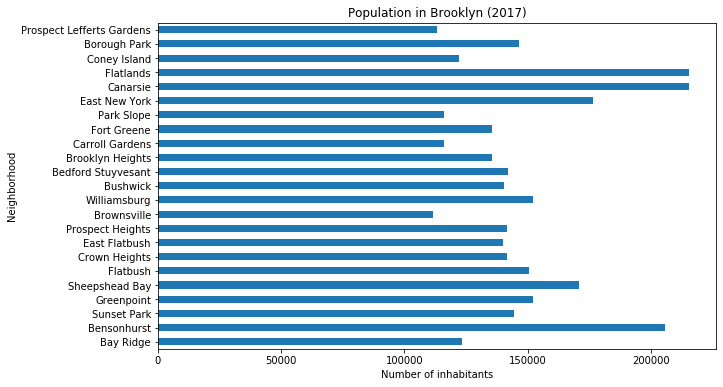

In [177]:
nycdata_new[['Neighborhood', 'Population']].plot(kind='barh', figsize=(10, 6), legend = None)
plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Population in Brooklyn (2017)') # add title to the plot
plt.yticks (np.arange(23), nycdata_new['Neighborhood'])
plt.show()

We can tell from the above plot that, the neighborhoods have most population would be Flatlands, Canarsie, Bensonhurst, etc. Now we can look at which Neighborhood would have most Asian Population

In [171]:
nycdata_new['Asian_Population'] = nycdata_new['Asian'] * nycdata_new['Population']
nycdata_new.head()

Neighborhood  Median Income  Population  Asian     AA  Hispanic    White  \
0       Bay Ridge        69989.0      123488  0.282  0.031     0.158  0.50900   
1     Bensonhurst        54513.0      205850  0.389  0.018     0.155  0.40400   
2     Sunset Park        57870.0      144332  0.327  0.024     0.399  0.22700   
3      Greenpoint        78069.0      152002  0.070  0.036     0.216  0.64500   
4  Sheepshead Bay        62443.0      171030  0.052  0.080     0.637  0.62443   

   Neighborhood Latitude  Neighborhood Longitude  Venue Latitude  \
0              40.625801              -74.030621       40.624251   
1              40.611009              -73.995180       40.612326   
2              40.645103              -74.010316       40.646869   
3              40.730201              -73.954241       40.730615   
4              40.586890              -73.943186       40.584168   

   Venue Longitude       Likes        Tips  American Restaurant  \
0       -74.030346   40.625000   40.625000             0.000000   
1       -73.996229   11.750000   11.750000             0.000000   
2       -74.009024   37.166667   37.166667             0.000000   
3       -73.955152  176.666667  176.666667             0.000000   
4       -73.944172   62.909091   62.909091             0.090909   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant       Bar  \
0               0.0                     0.0               0.0  0.125000   
1               0.0                     0.0               0.0  0.000000   
2               0.0                     0.0               0.0  0.000000   
3               0.0                     0.0               0.0  0.222222   
4               0.0                     0.0               0.0  0.000000   

   Cajun / Creole Restaurant  Caribbean Restaurant  Caucasian Restaurant  \
0                        0.0                   0.0                 0.125   
1                        0.0                   0.0                 0.000   
2                        0.0                   0.0                 0.000   
3                        0.0                   0.0                 0.000   
4                        0.0                   0.0                 0.000   

   Chinese Restaurant  Cocktail Bar  Cuban Restaurant  Dessert Shop  \
0               0.000      0.000000               0.0      0.000000   
1               0.125      0.000000               0.0      0.000000   
2               0.000      0.000000               0.0      0.000000   
3               0.000      0.111111               0.0      0.000000   
4               0.000      0.000000               0.0      0.272727   

   Dim Sum Restaurant  Dive Bar  Eastern European Restaurant  \
0                 0.0       0.0                          0.0   
1                 0.0       0.0                          0.0   
2                 0.0       0.0                          0.0   
3                 0.0       0.0                          0.0   
4                 0.0       0.0                          0.0   

   Falafel Restaurant  Fast Food Restaurant  Food  Food & Drink Shop  \
0                 0.0                   0.0   0.0                0.0   
1                 0.0                   0.0   0.0                0.0   
2                 0.0                   0.0   0.0                0.0   
3                 0.0                   0.0   0.0                0.0   
4                 0.0                   0.0   0.0                0.0   

   Food Court  Food Truck  French Restaurant  Gay Bar  German Restaurant  \
0         0.0         0.0           0.000000      0.0                0.0   
1         0.0         0.0           0.000000      0.0                0.0   
2         0.0         0.0           0.000000      0.0                0.0   
3         0.0         0.0           0.111111      0.0                0.0   
4         0.0         0.0           0.000000      0.0                0.0   

   Greek Restaurant  Health Food Store  Hookah Bar  Hotpot Restaurant  \
0              0.25    

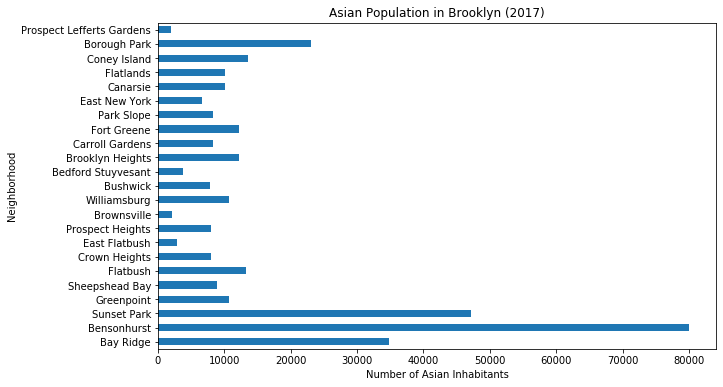

In [175]:
nycdata_new[['Neighborhood', 'Asian_Population']].plot(kind='barh', figsize=(10, 6), legend = None)
plt.xlabel('Number of Asian Inhabitants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Asian Population in Brooklyn (2017)') # add title to the plot
plt.yticks (np.arange(23), nycdata_new['Neighborhood'])
plt.show()

Given different Neighborhoods have different population bases. Looking at Asian Population by counts doesn't seem helpful. Lets look at Asian Population by Percentage.

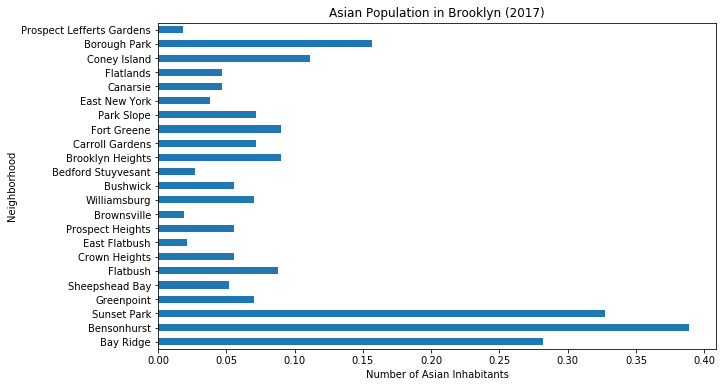

In [176]:
nycdata_new[['Neighborhood', 'Asian']].plot(kind='barh', figsize=(10, 6), legend = None)
plt.xlabel('Number of Asian Inhabitants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Asian Population in Brooklyn (2017)') # add title to the plot
plt.yticks (np.arange(23), nycdata_new['Neighborhood'])
plt.show()

Seems like most of the Asian people live in Sunset Park, Bensonhurst and Bay Ridge. 

#### Now we are going to look at incomes in the neighborhoods

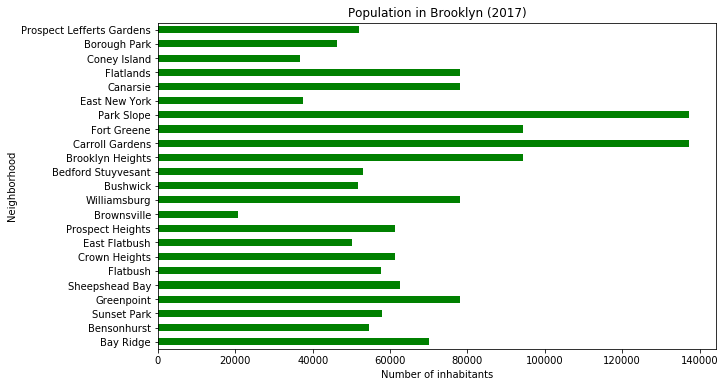

In [178]:
nycdata_new[['Neighborhood', 'Median Income']].plot(kind='barh', figsize=(10, 6), legend = None,color = 'green')
plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Population in Brooklyn (2017)') # add title to the plot
plt.yticks (np.arange(23), nycdata_new['Neighborhood'])
plt.show()

The neighborhoods have the higher median income are Park Slope and Carroll Gardens.

In [184]:
brooklyn_restaurant = brooklyn_venues_new[(brooklyn_venues_new['Venue Category'].str.contains('Restaurant', regex=False))].groupby(['Neighborhood']).count()
brooklyn_restaurant.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude','Venue ID'], axis = 1, inplace = True)
brooklyn_restaurant.rename(columns = {'Venue Category':'Number of restaurants'}, inplace=True)
brooklyn_restaurant.head()


Number of restaurants
Neighborhood                             
Bath Beach                              8
Bay Ridge                               5
Bedford Stuyvesant                      2
Bensonhurst                             8
Boerum Hill                             6

In [185]:
brooklyn_asian_restaurant = brooklyn_venues_new[(brooklyn_venues_new['Venue Category'].str.contains('Asian', regex=False))].groupby(['Neighborhood']).count()
brooklyn_asian_restaurant.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude','Venue ID'], axis = 1, inplace = True)
brooklyn_asian_restaurant.rename(columns = {'Venue Category':'Number of Asian restaurants'}, inplace=True)
brooklyn_asian_restaurant.head()


Number of Asian restaurants
Neighborhood                                 
Brooklyn Heights                            1
Canarsie                                    1
Highland Park                               1
Homecrest                                   1
New Lots                                    1

Given most of the neighborhoods have no or only 1 Asian restuarant, we won't use this as a metic.

In [188]:
nycdata_new = nycdata_new.merge(brooklyn_restaurant, on='Neighborhood', how='left')
nycdata_new

Neighborhood  Median Income  Population  Asian     AA  \
0                   Bay Ridge        69989.0      123488  0.282  0.031   
1                 Bensonhurst        54513.0      205850  0.389  0.018   
2                 Sunset Park        57870.0      144332  0.327  0.024   
3                  Greenpoint        78069.0      152002  0.070  0.036   
4              Sheepshead Bay        62443.0      171030  0.052  0.080   
5                    Flatbush        57678.0      150707  0.088  0.289   
6               Crown Heights        61253.0      141725  0.056  0.557   
7               East Flatbush        50290.0      140087  0.021  0.871   
8            Prospect Heights        61253.0      141725  0.056  0.557   
9                 Brownsville        20640.0      111511  0.019  0.713   
10               Williamsburg        78069.0      152002  0.070  0.036   
11                   Bushwick        51622.0      140474  0.056  0.170   
12         Bedford Stuyvesant        52897.0      142027  0.027  0.488   
13           Brooklyn Heights        94327.0      135444  0.090  0.258   
14            Carroll Gardens       137375.0      116209  0.072  0.061   
15                Fort Greene        94327.0      135444  0.090  0.258   
16                 Park Slope       137375.0      116209  0.072  0.061   
17              East New York        37488.0      176461  0.038  0.528   
18                   Canarsie        78109.0      215637  0.047  0.622   
19                  Flatlands        78109.0      215637  0.047  0.622   
20               Coney Island        36807.0      122009  0.111  0.125   
21               Borough Park        46229.0      146556  0.157  0.018   
22  Prospect Lefferts Gardens        52046.0      113212  0.018  0.602   

    Hispanic    White  Neighborhood Latitude  Neighborhood Longitude  \
0      0.158  0.50900              40.625801              -74.030621   
1      0.155  0.40400              40.611009              -73.995180   
2      0.399  0.22700              40.645103              -74.010316   
3      0.216  0.64500              40.730201              -73.954241   
4      0.637  0.62443              40.586890              -73.943186   
5      0.150  0.44200              40.636326              -73.958401   
6      0.117  0.24100              40.670829              -73.943291   
7      0.062  0.02700              40.641718              -73.936103   
8      0.117  0.24100              40.676822              -73.964859   
9      0.198  0.04300              40.663950              -73.910235   
10     0.216  0.64500              40.707144              -73.958115   
11     0.539  0.21500              40.698116              -73.925258   
12     0.194  0.26600              40.687232              -73.941785   
13     0.149  0.47200              40.695864              -73.993782   
14     0.172  0.63900              40.680540              -73.994654   
15     0.149  0.47200              40.688527              -73.972906   
16     0.172  0.63900              40.672321              -73.977050   
17     0.382  0.03900              40.669926              -73.880699   
18     0.088  0.22400              40.635564              -73.902093   
19     0.088  0.22400              40.630446              -73.929113   
20     0.187  0.55400              40.574293              -73.988683   
21     0.120  0.68900              40.633131              -73.990498   
22     0.098  0.25500              40.658420              -73.954899   

    Venue Latitude  Venue Longitude       Likes        Tips  \
0        40.624251       -74.030346   40.625000   40.625000   
1        40.612326       -73.996229   11.750000   11.750000   
2        40.646869       -74.009024   37.166667   37.166667   
3        40.730615       -73.955152  176.666667  176.666667   
4        40.584168       -73.944172   62.909091   62.909091   
5        40.635423       -73.961846    9.142857    9.142857   
6        40.670715       -73.944628    5.000000    5.000000   
7      

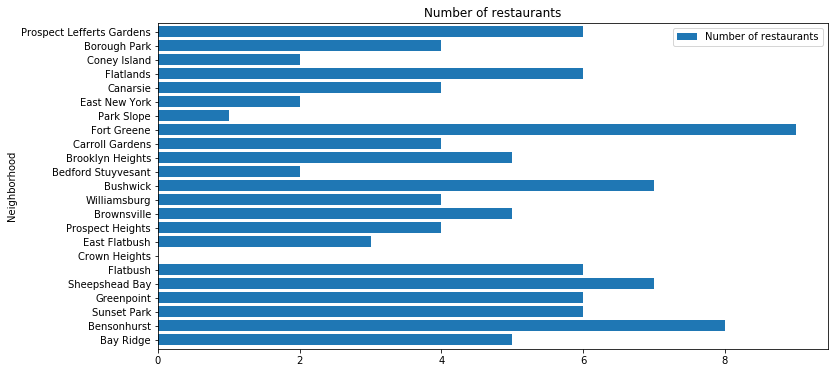

In [205]:
nycdata_new[['Number of restaurants']].plot(kind='barh', figsize=(12, 6), width = 0.8)
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Number of restaurants') # add title to the plot
plt.yticks(np.arange(23), nycdata_new['Neighborhood'])
plt.show()

#### 3.2 Cluster Analysis

In order to identify groups (clusters) with similar characteristics, let's us apply the unsupervised learning method to our data, namely K-Means algorithm. But before that, we can reduce the number of features by looking at the variance of each variable. Low variance means there's no difference among different neighborhood, so we should not include those noise in our model.

In [211]:
nycdata_t = nycdata_new.T.iloc[1:,:]

In [229]:
var_df = nycdata_t.var(axis=1).to_frame()

In [235]:
variable_list = var_df[var_df[0] >0].index

In [261]:
nycdata_new.index = nycdata_new['Neighborhood']

In [263]:
nycdata_new.drop('Neighborhood', 1)

Median Income  Population  Asian     AA  Hispanic  \
Neighborhood                                                                   
Bay Ridge                        69989.0      123488  0.282  0.031     0.158   
Bensonhurst                      54513.0      205850  0.389  0.018     0.155   
Sunset Park                      57870.0      144332  0.327  0.024     0.399   
Greenpoint                       78069.0      152002  0.070  0.036     0.216   
Sheepshead Bay                   62443.0      171030  0.052  0.080     0.637   
Flatbush                         57678.0      150707  0.088  0.289     0.150   
Crown Heights                    61253.0      141725  0.056  0.557     0.117   
East Flatbush                    50290.0      140087  0.021  0.871     0.062   
Prospect Heights                 61253.0      141725  0.056  0.557     0.117   
Brownsville                      20640.0      111511  0.019  0.713     0.198   
Williamsburg                     78069.0      152002  0.070  0.036     0.216   
Bushwick                         51622.0      140474  0.056  0.170     0.539   
Bedford Stuyvesant               52897.0      142027  0.027  0.488     0.194   
Brooklyn Heights                 94327.0      135444  0.090  0.258     0.149   
Carroll Gardens                 137375.0      116209  0.072  0.061     0.172   
Fort Greene                      94327.0      135444  0.090  0.258     0.149   
Park Slope                      137375.0      116209  0.072  0.061     0.172   
East New York                    37488.0      176461  0.038  0.528     0.382   
Canarsie                         78109.0      215637  0.047  0.622     0.088   
Flatlands                        78109.0      215637  0.047  0.622     0.088   
Coney Island                     36807.0      122009  0.111  0.125     0.187   
Borough Park                     46229.0      146556  0.157  0.018     0.120   
Prospect Lefferts Gardens        52046.0      113212  0.018  0.602     0.098   

                             White  Neighborhood Latitude  \
Neighborhood                                                
Bay Ridge                  0.50900              40.625801   
Bensonhurst                0.40400              40.611009   
Sunset Park                0.22700              40.645103   
Greenpoint                 0.64500              40.730201   
Sheepshead Bay             0.62443              40.586890   
Flatbush                   0.44200              40.636326   
Crown Heights              0.24100              40.670829   
East Flatbush              0.02700              40.641718   
Prospect Heights           0.24100              40.676822   
Brownsville                0.04300              40.663950   
Williamsburg               0.64500              40.707144   
Bushwick                   0.21500              40.698116   
Bedford Stuyvesant         0.26600              40.687232   
Brooklyn Heights           0.47200              40.695864   
Carroll Gardens            0.63900              40.680540   
Fort Greene                0.47200              40.688527   
Park Slope                 0.63900              40.672321   
East New York              0.03900              40.669926   
Canarsie                   0.22400              40.635564   
Flatlands                  0.22400              40.630446   
Coney Island               0.55400              40.574293   
Borough Park               0.68900              40.633131   
Prospect Lefferts Gardens  0.25500              40.658420   

                           Neighborhood Longitude  Venue Latitude  \
Neighborhood                                                        
Bay Ridge                              -74.030621       40.624251   
Bensonhurst                            -73.995180       40.612326   
Sunset Park                            -74.010316       40.646869   
Greenpoint                             -73.954241       40.730615   
Sheepshead Bay                         -73.943186       40.584168   
Flatbush         

In [276]:
nycdata_to_model = nycdata_new[variable_list]
nycdata_to_model

Median Income  Population  Asian     AA  Hispanic  \
Neighborhood                                                                   
Bay Ridge                        69989.0      123488  0.282  0.031     0.158   
Bensonhurst                      54513.0      205850  0.389  0.018     0.155   
Sunset Park                      57870.0      144332  0.327  0.024     0.399   
Greenpoint                       78069.0      152002  0.070  0.036     0.216   
Sheepshead Bay                   62443.0      171030  0.052  0.080     0.637   
Flatbush                         57678.0      150707  0.088  0.289     0.150   
Crown Heights                    61253.0      141725  0.056  0.557     0.117   
East Flatbush                    50290.0      140087  0.021  0.871     0.062   
Prospect Heights                 61253.0      141725  0.056  0.557     0.117   
Brownsville                      20640.0      111511  0.019  0.713     0.198   
Williamsburg                     78069.0      152002  0.070  0.036     0.216   
Bushwick                         51622.0      140474  0.056  0.170     0.539   
Bedford Stuyvesant               52897.0      142027  0.027  0.488     0.194   
Brooklyn Heights                 94327.0      135444  0.090  0.258     0.149   
Carroll Gardens                 137375.0      116209  0.072  0.061     0.172   
Fort Greene                      94327.0      135444  0.090  0.258     0.149   
Park Slope                      137375.0      116209  0.072  0.061     0.172   
East New York                    37488.0      176461  0.038  0.528     0.382   
Canarsie                         78109.0      215637  0.047  0.622     0.088   
Flatlands                        78109.0      215637  0.047  0.622     0.088   
Coney Island                     36807.0      122009  0.111  0.125     0.187   
Borough Park                     46229.0      146556  0.157  0.018     0.120   
Prospect Lefferts Gardens        52046.0      113212  0.018  0.602     0.098   

                             White  Neighborhood Latitude  \
Neighborhood                                                
Bay Ridge                  0.50900              40.625801   
Bensonhurst                0.40400              40.611009   
Sunset Park                0.22700              40.645103   
Greenpoint                 0.64500              40.730201   
Sheepshead Bay             0.62443              40.586890   
Flatbush                   0.44200              40.636326   
Crown Heights              0.24100              40.670829   
East Flatbush              0.02700              40.641718   
Prospect Heights           0.24100              40.676822   
Brownsville                0.04300              40.663950   
Williamsburg               0.64500              40.707144   
Bushwick                   0.21500              40.698116   
Bedford Stuyvesant         0.26600              40.687232   
Brooklyn Heights           0.47200              40.695864   
Carroll Gardens            0.63900              40.680540   
Fort Greene                0.47200              40.688527   
Park Slope                 0.63900              40.672321   
East New York              0.03900              40.669926   
Canarsie                   0.22400              40.635564   
Flatlands                  0.22400              40.630446   
Coney Island               0.55400              40.574293   
Borough Park               0.68900              40.633131   
Prospect Lefferts Gardens  0.25500              40.658420   

                           Neighborhood Longitude  Venue Latitude  \
Neighborhood                                                        
Bay Ridge                              -74.030621       40.624251   
Bensonhurst                            -73.995180       40.612326   
Sunset Park                            -74.010316       40.646869   
Greenpoint                             -73.954241       40.730615   
Sheepshead Bay                         -73.943186       40.584168   
Flatbush         

In [277]:
nycdata_to_model = nycdata_to_model.fillna(0)

In [278]:
print('We removed ' + str(nycdata_new.shape[1] - nycdata_to_model.shape[1]), 'variables from the data frame')

We removed 23 variables from the data frame


#### Normalize the data before the model

In [279]:
from sklearn.preprocessing import StandardScaler
nycdata_to_model = StandardScaler().fit_transform(nycdata_to_model)
nycdata_to_model

array([[ 0.095796  , -0.83397806,  1.89126637, ..., -0.38729833,
         1.15468096,  0.17773931],
       [-0.4634783 ,  1.93981744,  2.99133881, ..., -0.38729833,
         3.78962237,  1.54040739],
       [-0.34216247, -0.13199179,  2.35391366, ..., -0.38729833,
         1.87513461,  0.631962  ],
       ...,
       [-1.10334073, -0.88378796,  0.13320666, ..., -0.38729833,
        -0.08444962, -1.18492876],
       [-0.7628469 , -0.0570917 ,  0.606135  , ..., -0.38729833,
         0.46675494, -0.27648338],
       [-0.55263117, -1.18005419, -0.82293107, ..., -0.38729833,
        -0.75437493,  0.631962  ]])

#### To identify the optimal number of clusters, the Elbow method is used:

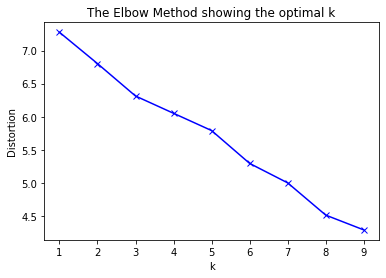

In [280]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(nycdata_to_model)
    kmeanModel.fit(nycdata_to_model)
    distortions.append(sum(np.min(cdist(nycdata_to_model, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / nycdata_to_model.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Seems like the first Elbow shows up when k = 3

In [281]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nycdata_to_model)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:22]

array([1, 0, 0, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 0],
      dtype=int32)

Let's insert the Cluster labels into our master dataframe.

In [282]:
nycdata_new.insert(0, 'Cluster Labels', kmeans.labels_)
nycdata_new.head()

Cluster Labels    Neighborhood  Median Income  Population  \
Neighborhood                                                                
Bay Ridge                    1       Bay Ridge        69989.0      123488   
Bensonhurst                  0     Bensonhurst        54513.0      205850   
Sunset Park                  0     Sunset Park        57870.0      144332   
Greenpoint                   1      Greenpoint        78069.0      152002   
Sheepshead Bay               0  Sheepshead Bay        62443.0      171030   

                Asian     AA  Hispanic    White  Neighborhood Latitude  \
Neighborhood                                                             
Bay Ridge       0.282  0.031     0.158  0.50900              40.625801   
Bensonhurst     0.389  0.018     0.155  0.40400              40.611009   
Sunset Park     0.327  0.024     0.399  0.22700              40.645103   
Greenpoint      0.070  0.036     0.216  0.64500              40.730201   
Sheepshead Bay  0.052  0.080     0.637  0.62443              40.586890   

                Neighborhood Longitude  Venue Latitude  Venue Longitude  \
Neighborhood                                                              
Bay Ridge                   -74.030621       40.624251       -74.030346   
Bensonhurst                 -73.995180       40.612326       -73.996229   
Sunset Park                 -74.010316       40.646869       -74.009024   
Greenpoint                  -73.954241       40.730615       -73.955152   
Sheepshead Bay              -73.943186       40.584168       -73.944172   

                     Likes        Tips  American Restaurant  Arepa Restaurant  \
Neighborhood                                                                    
Bay Ridge        40.625000   40.625000             0.000000               0.0   
Bensonhurst      11.750000   11.750000             0.000000               0.0   
Sunset Park      37.166667   37.166667             0.000000               0.0   
Greenpoint      176.666667  176.666667             0.000000               0.0   
Sheepshead Bay   62.909091   62.909091             0.090909               0.0   

                Argentinian Restaurant  Asian Restaurant       Bar  \
Neighborhood                                                         
Bay Ridge                          0.0               0.0  0.125000   
Bensonhurst                        0.0               0.0  0.000000   
Sunset Park                        0.0               0.0  0.000000   
Greenpoint                         0.0               0.0  0.222222   
Sheepshead Bay                     0.0               0.0  0.000000   

                Cajun / Creole Restaurant  Caribbean Restaurant  \
Neighborhood                                                      
Bay Ridge                             0.0                   0.0   
Bensonhurst                           0.0                   0.0   
Sunset Park                           0.0                   0.0   
Greenpoint                            0.0                   0.0   
Sheepshead Bay                        0.0                   0.0   

                Caucasian Restaurant  Chinese Restaurant  Cocktail Bar  \
Neighborhood                                                             
Bay Ridge                      0.125               0.000      0.000000   
Bensonhurst                    0.000               0.125      0.000000   
Sunset Park                    0.000               0.000      0.000000   
Greenpoint                     0.000               0.000      0.111111   
Sheepshead Bay                 0.000               0.000      0.000000   

                Cuban Restaurant  Dessert Shop  Dim Sum Restaurant  Dive Bar  \
Neighborhood                                                                   
Bay Ridge                    0.0      0.000000                 0.0       0.0   
Bensonhurst                  0.0      0.000000                 0.0       0.0   
Sunset Park                  0.0      0.000000                 

Now, it's time to create maps representing our clusters. 

In [300]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nycdata_new['Neighborhood Latitude'], nycdata_new['Neighborhood Longitude'], nycdata_new['Neighborhood'], nycdata_new['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 3.3 Examine the clusters

Now we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

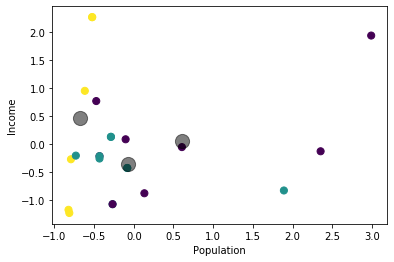

In [308]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(nycdata_to_model)
plt.scatter(nycdata_to_model[:, 2], nycdata_to_model[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Population')
plt.ylabel('Income')
plt.show()

In [312]:
nycdata_new[(nycdata_new['Cluster Labels'] == 0)][['Median Income','Population','Asian','Likes','Tips','Number of restaurants']].mean()

Median Income             64271.000000
Population               149802.250000
Asian                         0.156500
Likes                        32.433577
Tips                         32.433577
Number of restaurants         4.857143
dtype: float64

In [314]:
nycdata_new[(nycdata_new['Cluster Labels'] == 1)][['Median Income','Population','Asian','Likes','Tips','Number of restaurants']].mean()

Median Income             79769.777778
Population               137646.111111
Asian                         0.090333
Likes                       170.509524
Tips                        170.509524
Number of restaurants         5.111111
dtype: float64

In [316]:
nycdata_new[(nycdata_new['Cluster Labels'] == 2)][['Median Income','Population','Asian','Likes','Tips','Number of restaurants']].mean()

Median Income             52780.333333
Population               162090.833333
Asian                         0.031667
Likes                         9.558333
Tips                          9.558333
Number of restaurants         4.333333
dtype: float64

We can see from above:
- Cluster 0 have the 2nd most of people with the 2nd highest income and the most Asian population, and 2nd least restaurants.
- Cluster 1 have the least of people with the highest income and the 2nd most Asian population, most restaurants, and most likes and tips.
- Cluster 2 have the most of people with lowest income and the least Asian population, and least restaruants.

Based on the results above, we should aim for Cluster 1 since we want to target a high income neighborbood. 

Now, lets take a look at the restaurants belong to cluster 1


In [318]:
nycdata_new[(nycdata_new['Cluster Labels'] == 1)]

Cluster Labels        Neighborhood  Median Income  \
Neighborhood                                                            
Bay Ridge                        1           Bay Ridge        69989.0   
Greenpoint                       1          Greenpoint        78069.0   
Prospect Heights                 1    Prospect Heights        61253.0   
Williamsburg                     1        Williamsburg        78069.0   
Bushwick                         1            Bushwick        51622.0   
Bedford Stuyvesant               1  Bedford Stuyvesant        52897.0   
Brooklyn Heights                 1    Brooklyn Heights        94327.0   
Carroll Gardens                  1     Carroll Gardens       137375.0   
Fort Greene                      1         Fort Greene        94327.0   

                    Population  Asian     AA  Hispanic  White  \
Neighborhood                                                    
Bay Ridge               123488  0.282  0.031     0.158  0.509   
Greenpoint              152002  0.070  0.036     0.216  0.645   
Prospect Heights        141725  0.056  0.557     0.117  0.241   
Williamsburg            152002  0.070  0.036     0.216  0.645   
Bushwick                140474  0.056  0.170     0.539  0.215   
Bedford Stuyvesant      142027  0.027  0.488     0.194  0.266   
Brooklyn Heights        135444  0.090  0.258     0.149  0.472   
Carroll Gardens         116209  0.072  0.061     0.172  0.639   
Fort Greene             135444  0.090  0.258     0.149  0.472   

                    Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                        
Bay Ridge                       40.625801              -74.030621   
Greenpoint                      40.730201              -73.954241   
Prospect Heights                40.676822              -73.964859   
Williamsburg                    40.707144              -73.958115   
Bushwick                        40.698116              -73.925258   
Bedford Stuyvesant              40.687232              -73.941785   
Brooklyn Heights                40.695864              -73.993782   
Carroll Gardens                 40.680540              -73.994654   
Fort Greene                     40.688527              -73.972906   

                    Venue Latitude  Venue Longitude       Likes        Tips  \
Neighborhood                                                                  
Bay Ridge                40.624251       -74.030346   40.625000   40.625000   
Greenpoint               40.730615       -73.955152  176.666667  176.666667   
Prospect Heights         40.676587       -73.963800  177.900000  177.900000   
Williamsburg             40.709014       -73.956971  305.875000  305.875000   
Bushwick                 40.699513       -73.926408   94.100000   94.100000   
Bedford Stuyvesant       40.684215       -73.943584   95.142857   95.142857   
Brooklyn Heights         40.695981       -73.993911   74.800000   74.800000   
Carroll Gardens          40.680919       -73.994313  192.142857  192.142857   
Fort Greene              40.689098       -73.971816  377.333333  377.333333   

                    American Restaurant  Arepa Restaurant  \
Neighborhood                                                
Bay Ridge                           0.0               0.0   
Greenpoint                          0.0               0.0   
Prospect Heights                    0.0               0.0   
Williamsburg                        0.0               0.0   
Bushwick                            0.0               0.0   
Bedford Stuyvesant                  0.0               0.0   
Brooklyn Heights                    0.0               0.0   
Carroll Gardens                     0.0               0.0   
Fort Greene                         0.0               0.0   

                    Argentinian Restaurant  Asian Restaurant       Bar  \
Neighborhood                                                             
Bay Ridge                              0.0        

We have 9 Neighborhood in cluster 1. Among then, if we sort by Median Income, the top neighborhoods are:

In [325]:
lst1 = nycdata_new[(nycdata_new['Cluster Labels'] == 1)].sort_values('Median Income', ascending=False).head(5).index

Now, how about Asian Population:

In [326]:
lst2 = nycdata_new[(nycdata_new['Cluster Labels'] == 1)].sort_values('Asian', ascending=False).head(5).index

Now, how about population:

In [327]:
lst3 = nycdata_new[(nycdata_new['Cluster Labels'] == 1)].sort_values('Population', ascending=False).head(5).index

Now, lets find the neighborhood shows up in all above conditions:

In [329]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

intersection(intersection(lst1, lst2),lst3)

['Greenpoint']

### Greenpoint is our choice!

### 4. Results and discussion

During the analysis, three clusters were defined. If we look at the locations on the map, neighborhoods in each cluster tend to clustering together.  
When takeing a detailed look at the results, Cluster 0 have the 2nd most of people with the 2nd highest income and the most Asian population, and 2nd least restaurants. Cluster 1 have the least of people with the highest income and the 2nd most Asian population, most restaurants, and most likes and tips. Cluster 2 have the most of people with lowest income and the least Asian population, and least restaruants.  
Since our stakeholders want to open a high-end restaurant, we want to find the cluster having the most income and that would be the cluster 1. 
Then when looking at cluster 1, we want to find the neighborhood that have the most income, most population (Asian) and most overall population. The neighborhood match all requirements is Greenpoint.
However, one can perform further analysis of this particular cluster with additional features, such as distance to the center of city or to the center of cluster. After defining a Neighborhood one can perform deeper analysis to find the best exact location of the restaurant taking into account factors such as number of parking places in the vicinity of the spot or distances to the main streets.

What could be done better:
Foursquare doesn't represent the full picture, since many venues are not on the list. For that reason, another maps could be utilized such as Google map or Openstreet map.
Neighborhoods have too complex geometry, thus defining the closest venues within the certain radius brings additional error to our analysis.

### 5. Conclusion

To conclude, the basic data analysis was performed to identify the most optimal Neighborhood in Brooklyn for the placement of the high-end Chinese restaurant. During the analysis, several important statistical features of the Neighborhoods were explored and visualized. Furthermore, clustering helped to highlight the group of optimal areas. Finally, Greenpoint was chosen as the most attractive options for the further analysis.